<a href="https://colab.research.google.com/github/imanf18/KNN_FinalProject2/blob/main/KNN_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


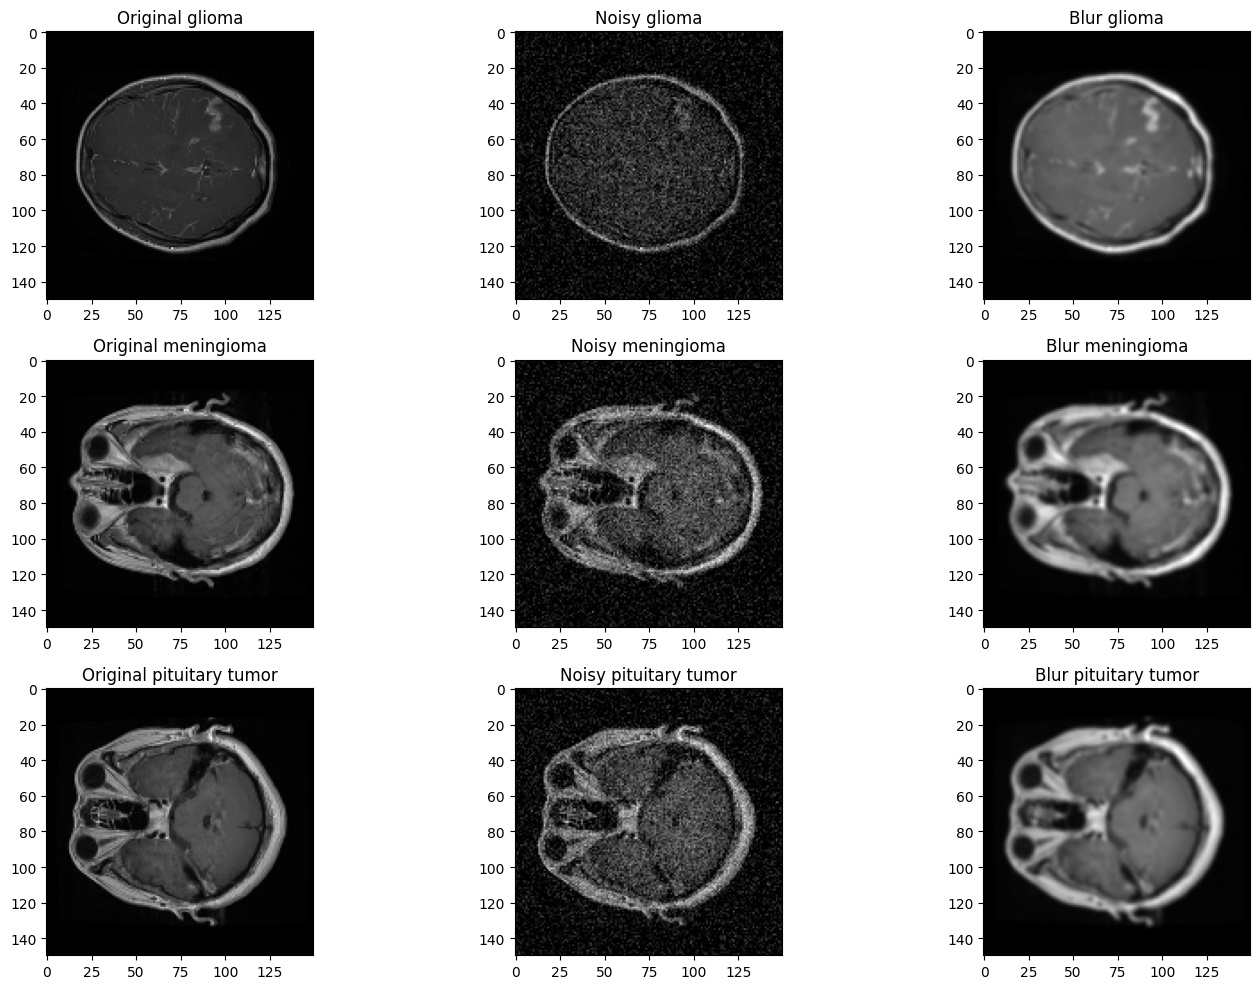

k=3, metric=euclidean - Train Accuracy: 0.9986111111111111, Test Accuracy: 0.9888888888888889
                 precision    recall  f1-score   support

         glioma       0.97      1.00      0.98        63
     meningioma       1.00      0.96      0.98        53
pituitary tumor       1.00      1.00      1.00        64

       accuracy                           0.99       180
      macro avg       0.99      0.99      0.99       180
   weighted avg       0.99      0.99      0.99       180

[[63  0  0]
 [ 2 51  0]
 [ 0  0 64]]
k=3, metric=manhattan - Train Accuracy: 0.9972222222222222, Test Accuracy: 0.9833333333333333
                 precision    recall  f1-score   support

         glioma       0.95      1.00      0.98        63
     meningioma       1.00      0.94      0.97        53
pituitary tumor       1.00      1.00      1.00        64

       accuracy                           0.98       180
      macro avg       0.98      0.98      0.98       180
   weighted avg       0.98   

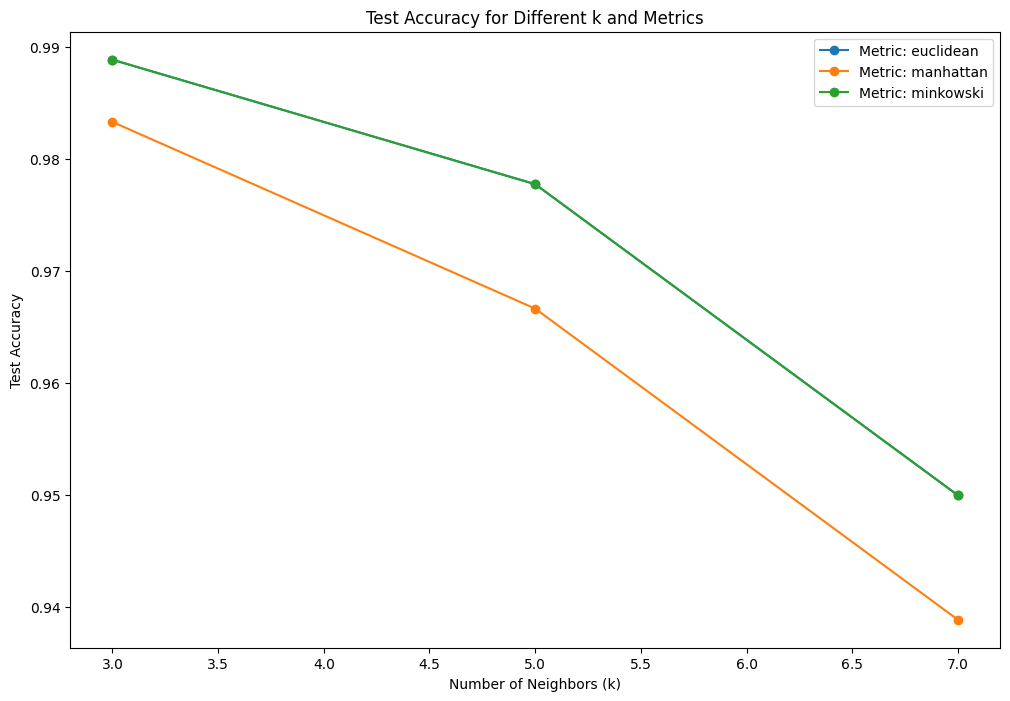

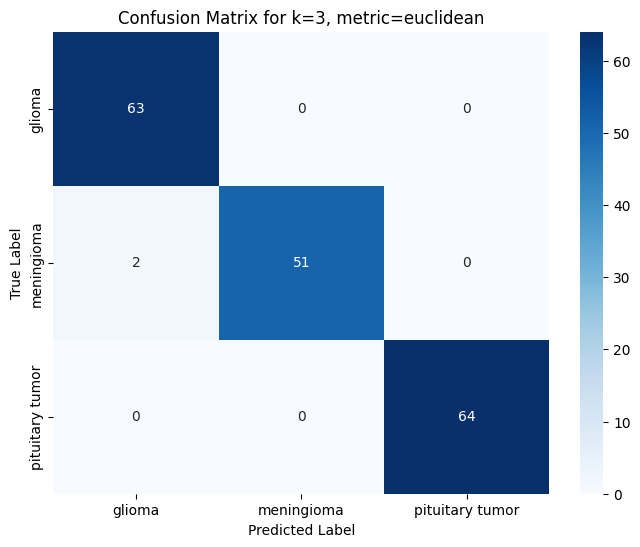

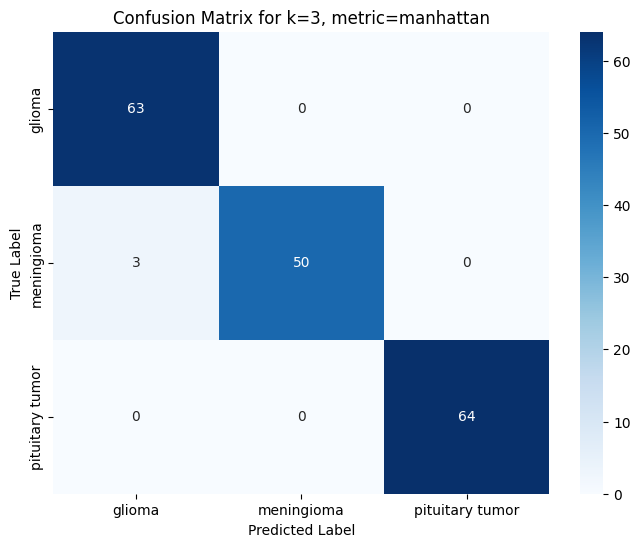

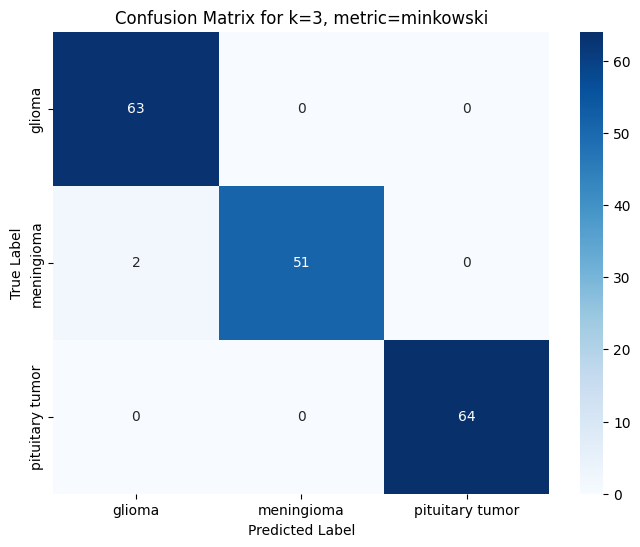

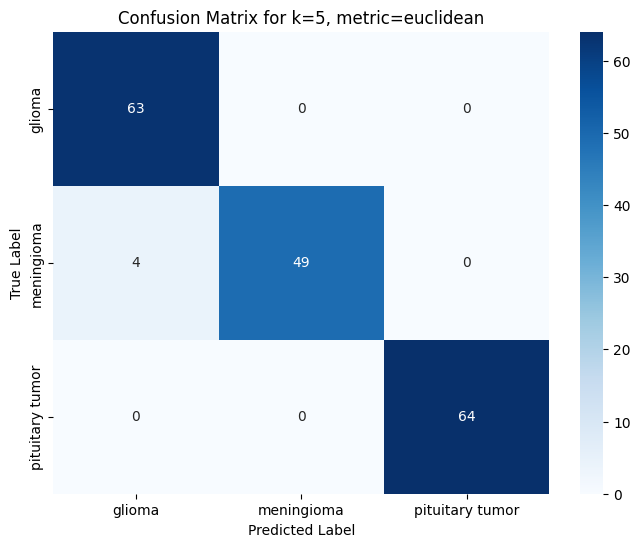

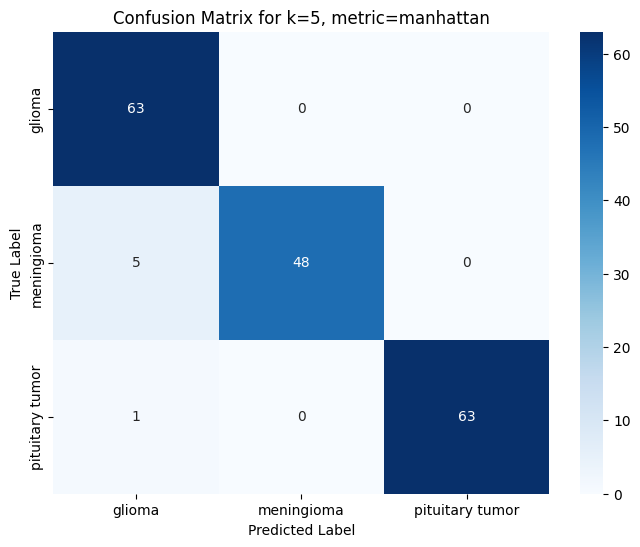

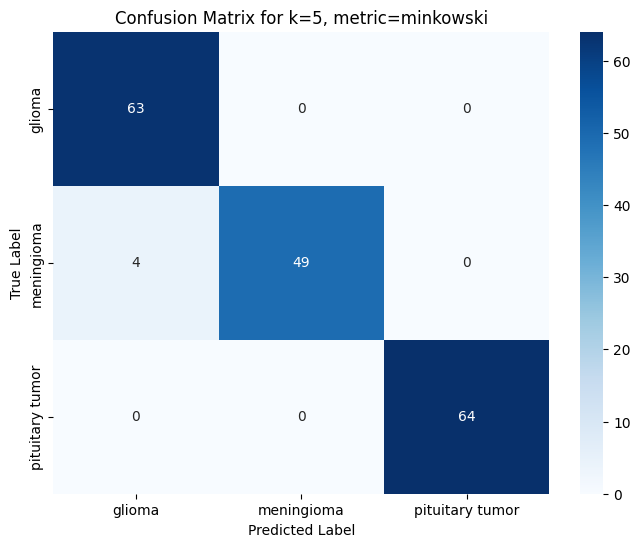

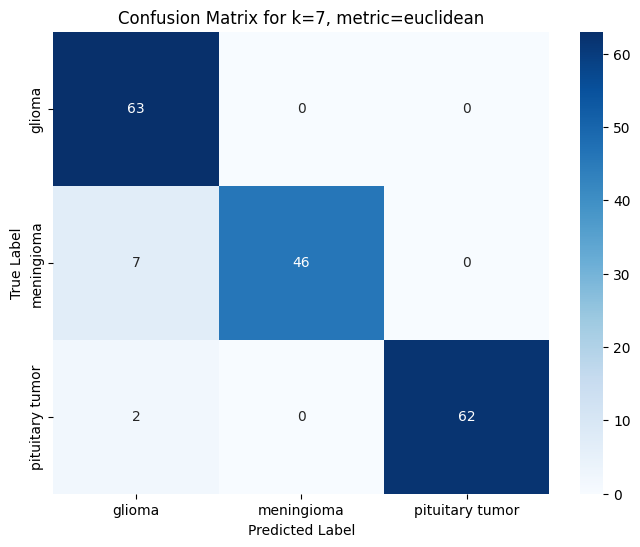

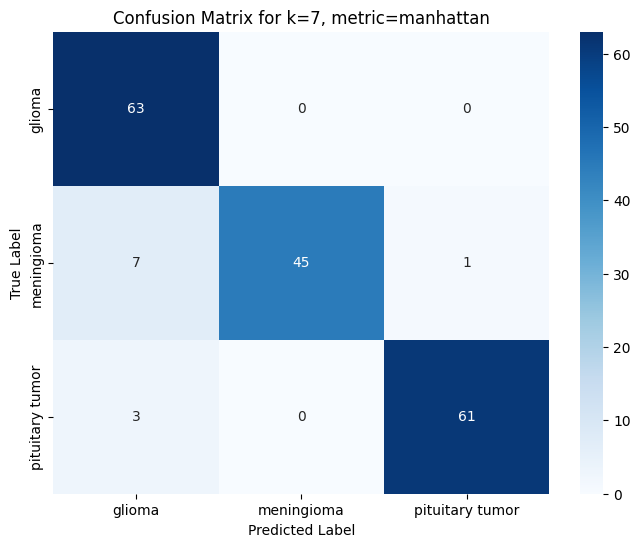

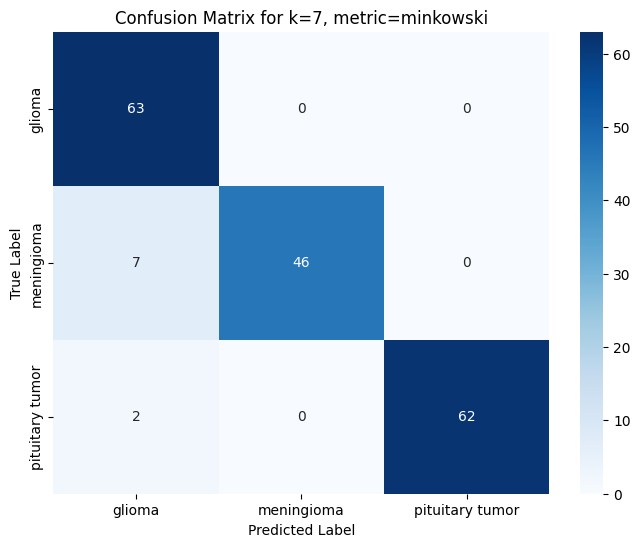

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install opencv-python-headless scikit-learn tensorflow

# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Directories
data_dir = '/content/drive/My Drive/Data 100'
categories = ['glioma', 'meningioma', 'pituitary tumor']

# Parameters
img_size = 150

# Function to load and preprocess images
def load_images(data_dir, categories, img_size):
    data = []
    labels = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_array = cv2.resize(img_array, (img_size, img_size))
                data.append(resized_array)
                labels.append(class_num)
            except Exception as e:
                print(e)
    return np.array(data), np.array(labels)

# Load images
data, labels = load_images(data_dir, categories, img_size)

# Normalize the data
data = data / 255.0

# Augmentation functions
def add_noise(img):
    noise_factor = 0.1
    noisy_img = img + noise_factor * np.random.randn(*img.shape)
    noisy_img = np.clip(noisy_img, 0., 1.)
    return noisy_img

def blur_image(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

# Visualize augmented images
def visualize_augmentations(data, labels, categories):
    fig, axes = plt.subplots(len(categories), 3, figsize=(15, 10))
    for i, category in enumerate(categories):
        idx = np.where(labels == i)[0]
        original_img = data[idx[0]]
        noisy_img = add_noise(original_img)
        blur_img = blur_image(original_img)
        axes[i, 0].imshow(original_img, cmap='gray')
        axes[i, 0].set_title(f'Original {category}')
        axes[i, 1].imshow(noisy_img, cmap='gray')
        axes[i, 1].set_title(f'Noisy {category}')
        axes[i, 2].imshow(blur_img, cmap='gray')
        axes[i, 2].set_title(f'Blur {category}')
    plt.tight_layout()
    plt.show()

visualize_augmentations(data, labels, categories)

# Augment the dataset
def augment_data(data, labels):
    noisy_data = np.array([add_noise(img) for img in data])
    blur_data = np.array([blur_image(img) for img in data])

    augmented_data = np.concatenate((data, noisy_data, blur_data))
    augmented_labels = np.concatenate((labels, labels, labels))

    return augmented_data, augmented_labels

augmented_data, augmented_labels = augment_data(data, labels)

# Flatten the images for KNN
n_samples = len(augmented_data)
flattened_data = augmented_data.reshape(n_samples, -1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(flattened_data, augmented_labels, test_size=0.2, random_state=42)

# Function to train KNN and get accuracy
def train_knn(X_train, y_train, X_test, y_test, n_neighbors, metric):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    cls_report = classification_report(y_test, y_pred_test, target_names=categories)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    return train_acc, test_acc, cls_report, conf_matrix

# Combinations of neighbor and distance metrics
neighbors = [3, 5, 7]
metrics = ['euclidean', 'manhattan', 'minkowski']

# Store results
results = {}

for n in neighbors:
    for metric in metrics:
        train_acc, test_acc, cls_report, conf_matrix = train_knn(X_train, y_train, X_test, y_test, n_neighbors=n, metric=metric)
        results[(n, metric)] = {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'cls_report': cls_report,
            'conf_matrix': conf_matrix
        }
        print(f'k={n}, metric={metric} - Train Accuracy: {train_acc}, Test Accuracy: {test_acc}')
        print(cls_report)
        print(conf_matrix)

# Plot accuracy results
fig, ax = plt.subplots(figsize=(12, 8))

for metric in metrics:
    k_vals = [n for n, m in results if m == metric]
    test_accuracies = [results[(n, metric)]['test_acc'] for n in k_vals]
    ax.plot(k_vals, test_accuracies, marker='o', label=f'Metric: {metric}')

ax.set_xlabel('Number of Neighbors (k)')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy for Different k and Metrics')
ax.legend()
plt.show()

# Plot confusion matrices
for n in neighbors:
    for metric in metrics:
        conf_matrix = results[(n, metric)]['conf_matrix']
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
        plt.title(f'Confusion Matrix for k={n}, metric={metric}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
